## 1. Librerías y configuración incial

In [14]:
#!pip install rpy2

In [15]:
import pandas as pd             # manipulación de datos
import numpy as np              # manipulación de datos

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R 
library(tidyverse)

In [28]:
%%R
#.libPaths()

NULL


# 2. Datos

Los datos son del paquete AER, los subí al repo para leer directo sin tener que instalar el paquete. 

In [19]:
%%R -o CASchools 
CASchools <- readr::read_csv('https://raw.githubusercontent.com/karbartolome/rladies_charlas/main/01_r_python/02_slides/data/CASchools.csv')


-- Column specification --------------------------------------------------------
cols(
  district = col_double(),
  school = col_character(),
  county = col_character(),
  grades = col_character(),
  students = col_double(),
  teachers = col_double(),
  calworks = col_double(),
  lunch = col_double(),
  computer = col_double(),
  expenditure = col_double(),
  income = col_double(),
  english = col_double(),
  read = col_double(),
  math = col_double()
)



# 3. Modelo

Se busca predecir el desempeño en matemática en función de ciertas variables:

In [20]:
CASchools.head(2)

,district,school,county,grades,students,teachers,calworks,lunch,computer,expenditure,income,english,read,math
1,75119.0,Sunol Glen Unified,Alameda,KK-08,195.0,10.90,0.5102,2.040800,67.0,6384.911133,22.690001,0.000000,691.599976,690.000000
2,61499.0,Manzanita Elementary,Butte,KK-08,240.0,11.15,15.4167,47.916698,101.0,5099.380859,9.824000,4.583333,660.500000,661.900024


In [21]:
#CASchools.describe(include='all').transpose()

In [22]:
df = (CASchools 
    .assign(tamaño = lambda x: x['students']/x['teachers'])
    
    [['math','tamaño','expenditure','students','lunch','teachers','calworks','income','english']]

    .copy()
)

df.head(2)

,math,tamaño,expenditure,students,lunch,teachers,calworks,income,english
1,690.000000,17.889909,6384.911133,195.0,2.040800,10.90,0.5102,22.690001,0.000000
2,661.900024,21.524664,5099.380859,240.0,47.916698,11.15,15.4167,9.824000,4.583333


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

X = df.drop('math',axis=1).copy()
y = df['math']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipe = Pipeline([
  ('imputador',      SimpleImputer(strategy='constant', fill_value= 0)),
  ('scaler',         StandardScaler()), 
  ('random_forest',  RandomForestRegressor(n_estimators=100, random_state=42))
])
  
pipe.fit(X_train, y_train)
modelo = pipe['random_forest']

In [24]:
importancia = pd.DataFrame({'variable':X_train.columns,
              'importancia':modelo.feature_importances_})

importancia.sort_values('importancia',ascending=False)

,variable,importancia
3,lunch,0.672462
6,income,0.107199
5,calworks,0.061918
0,tamaño,0.036401
7,english,0.034881
1,expenditure,0.033323
2,students,0.027200
4,teachers,0.026616


Predicciones en test

In [25]:
preds_test = pd.DataFrame({'math':y_test, 
                           'math_pred':pipe.predict(X_test)
                           })

preds_test

,math,math_pred
146,643.400024,639.953995
335,674.099976,651.174002
176,646.500000,645.716995
370,673.200012,662.256003
417,709.500000,690.240001
...,...,...
266,663.599976,659.889999
17,624.400024,622.005999
389,684.900024,663.837000
249,663.200012,658.199002


# 4. Visualización de resultados

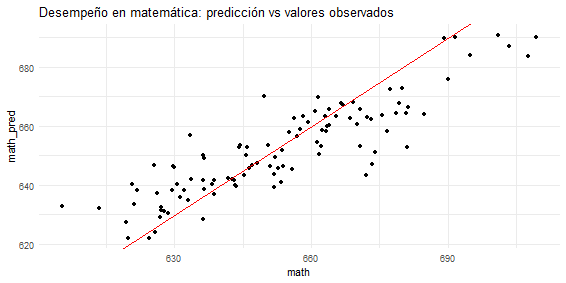

In [26]:
%%R -i preds_test -w 20 -h 10 --units cm

library(tidyverse)

preds_test %>% 
  ggplot(aes(x=math, y=math_pred))+
  geom_point()+
  geom_abline(intercept=0, slope=1, color='red')+
  labs(title = "Desempeño en matemática: predicción vs valores observados")+
  theme_minimal()


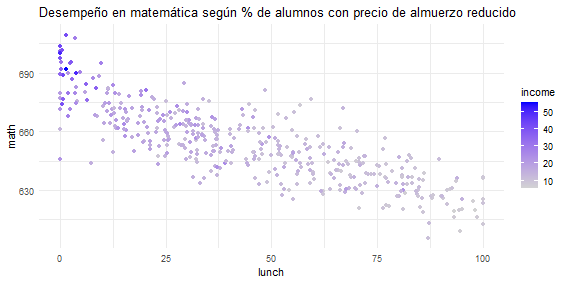

In [27]:
%%R -w 20 -h 10 --units cm

library(tidyverse)

CASchools %>% 
  ggplot(aes(x=lunch, y=math, color=income))+
  geom_point()+
  scale_color_gradient(low='lightgrey',  high='blue')+
  labs(title = "Desempeño en matemática según % de alumnos con precio de almuerzo reducido")+
  theme_minimal()